In [10]:
import json
import re

import pandas as pd
import numpy as np

from datetime import datetime
from typing import Dict, List
from tqdm import tqdm

# Embedding algorithm essentials
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize


In [11]:
df_db_tracks = pd.read_csv('../dataset/tracks.csv')
df_db_tracks['id_artists'] = df_db_tracks['id_artists'].apply(lambda x: x[1:-1].strip().replace("'", "").split(','))
df_db_tracks.head(2)

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,35iwgR4jXetI318WEWsa1Q,Carve,6,126903,0,['Uli'],[45tIt06XoI0Iio4LBEVpls],1922-02-22,0.645,0.445,0,-13.338,1,0.451,0.674,0.744,0.151,0.127,104.851,3
1,021ht4sdgPcrDgSk7JTbKY,Capítulo 2.16 - Banquero Anarquista,0,98200,0,['Fernando Pessoa'],[14jtPCOoNZwquk5wd9DxrY],1922-06-01,0.695,0.263,0,-22.136,1,0.957,0.797,0.000,0.148,0.655,102.009,1


In [68]:
def convert_string_to_list(x: str) -> List:
    l = list(x[1:-1].strip().split(','))
    if "" in l: l.remove("")
    return [
        item.strip("'") for item in l
    ]

In [70]:
df_db_artists = pd.read_csv('../dataset/artists.csv')
df_db_artists['genres'] = df_db_artists['genres'].apply(lambda x: convert_string_to_list(x))
df_db_artists.tail(2)

,id,followers,genres,name,popularity
1162093,5nvjpU3Y7L6Hpe54QuvDjy,2357.0,[black comedy],Donnell Rawlings,15
1162094,2bP2cNhNBdKXHC6AnqgyVp,40.0,[new comedy],Gabe Kea,8


In [71]:
artist_information = df_db_artists.set_index('id').to_dict(orient='index')

In [72]:
def get_genres_for_artists(id_artists: List[str]) -> List[str]:
    genres = []
    for artist_id in id_artists:
        genres += artist_information[artist_id]['genres'] if artist_id in artist_information.keys() else []
    genres = list(set(genres))
    if '' in genres: genres.remove('')
    return genres


def get_popularity_for_artists(id_artists: List[str]) -> List[int]:
    popularity = []
    for artist_id in id_artists:
        popularity += [artist_information[artist_id]['popularity']] if artist_id in artist_information.keys() else []
    return popularity

In [73]:
df_db_tracks['genres'] = df_db_tracks['id_artists'].apply(lambda x: get_genres_for_artists(x))
df_db_tracks.head(1)

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,genres
0,35iwgR4jXetI318WEWsa1Q,Carve,6,126903,0,['Uli'],[45tIt06XoI0Iio4LBEVpls],1922-02-22,0.645,0.445,...,-13.338,1,0.451,0.674,0.744,0.151,0.127,104.851,3,[]


#### Artist Representation

Create the artist social network, concatenated artist ids, for which we will create embeddings with w2v

1. Collaboration relationship
2. References relationship
3. Concert relationship
4. Co-existence in playlists relationship

In [74]:
# collaborations
df_db_tracks_artists = df_db_tracks[['id', 'id_artists']]
collaborations = df_db_tracks_artists.to_dict('records')
collaborations = [[a.strip() for a in track['id_artists']] for track in collaborations]

In [17]:
import json

with open('../dataset/artists_wiki_graph.json') as json_file:
    references = json.load(json_file)


with open('../dataset/concerts_artists_graph.json') as json_file:
    concerts = json.load(json_file)

In [75]:
graph = {}

concert_weight = 2
collaboration_weight = 4
reference_weight = 1
playlist_coexistence = 3

for track_artists_id in tqdm(collaborations):
    # O(n^2) complexity for artists
    for artist_root in track_artists_id:
        for artist_edge in track_artists_id:
            if artist_root == artist_edge: continue
            
            if artist_root not in graph:
                graph[artist_root] = {}
            
            if artist_edge not in graph[artist_root]:
                graph[artist_root][artist_edge] = 0
            
            graph[artist_root][artist_edge] += collaboration_weight


for page_references in tqdm(references):
    # O(n^2) complexity for artists
    for artist_root in page_references['artists']:
        for artist_edge in page_references['artists']:
            if artist_root == artist_edge: continue
            
            if artist_root not in graph:
                graph[artist_root] = {}
            
            if artist_edge not in graph[artist_root]:
                graph[artist_root][artist_edge] = 0
            
            graph[artist_root][artist_edge] += reference_weight



for page_references in tqdm(concerts):
    # O(n^2) complexity for artists
    for artist_root in page_references['artists']:
        for artist_edge in page_references['artists']:
            if artist_root == artist_edge: continue
            
            if artist_root not in graph:
                graph[artist_root] = {}
            
            if artist_edge not in graph[artist_root]:
                graph[artist_root][artist_edge] = 0
            
            graph[artist_root][artist_edge] += concert_weight

100%|██████████| 2272/2272 [00:00<00:00, 4724.53it/s]


In [82]:
from pecanpy import pecanpy
from pecanpy.graph import AdjlstGraph

# load graph object using SparseOTF mode
g = pecanpy.SparseOTF(p=1, q=1, workers=4, verbose=True)

adjl_graph = AdjlstGraph()
for artist in graph:
    adjl_graph.add_node(artist)
    for artist_to in graph[artist]:
        adjl_graph.add_node(artist_to)
        adjl_graph.add_edge(artist, artist_to, weight=graph[artist][artist_to], directed=False)


g = pecanpy.SparseOTF(p=1, q=1, workers=4, verbose=True)
g = g.from_adjlst_graph(adjl_graph)

In [83]:
# generate random walks
walks = g.simulate_walks(num_walks=100, walk_length=20)

In [84]:
print("Total number of graph nodes:", g.num_nodes)
print("Total number of graph edges:", g.num_edges)

Total number of graph nodes: 79694
Total number of graph edges: 7754928


In [90]:
# use random walks to train embeddings
mdl = Word2Vec(walks, vector_size=16, window=2, min_count=0, sg=1, workers=4, epochs=10)

In [91]:
input_node = '5JZ7CnR6gTvEMKX4g70Amv'
for s in mdl.wv.most_similar(input_node, topn = 10):
    print(s)

('4Uc8Dsxct0oMqx0P6i60ea', 0.9882261157035828)
('7licaqhcEBQUzz9FownRaJ', 0.9843418002128601)
('2IUl3m1H1EQ7QfNbNWvgru', 0.959147036075592)
('1BhWF9W2PngtPSyobKg0rP', 0.9077832102775574)
('4frHO7KPcfMjhnVdIMJ98c', 0.8903582096099854)
('6dJeKm76NjfXBNTpHmOhfO', 0.8814095854759216)
('5fyHpJg1xW8OZqPyzmQv2C', 0.8805928230285645)
('4MyWiEx9IqhsrfASgFHJQ3', 0.8780027627944946)
('4Lg9mKgNZBK7l8JkVT67o1', 0.8769657611846924)
('0Uo6kyjrbQoZBlcXsMb8Vm', 0.8742133975028992)


In [76]:
df_db_artists['num_genres_tagged'] = df_db_artists['genres'].apply(lambda x: len(x))

In [77]:
df_db_artists[df_db_artists['name']=='Dua Lipa']

,id,followers,genres,name,popularity,num_genres_tagged
144487,6M2wZ9GZgrQXHCFfjv46we,24123468.0,"[dance pop, 'pop, 'uk pop]",Dua Lipa,95,3


<Axes: xlabel='num_genres_tagged'>

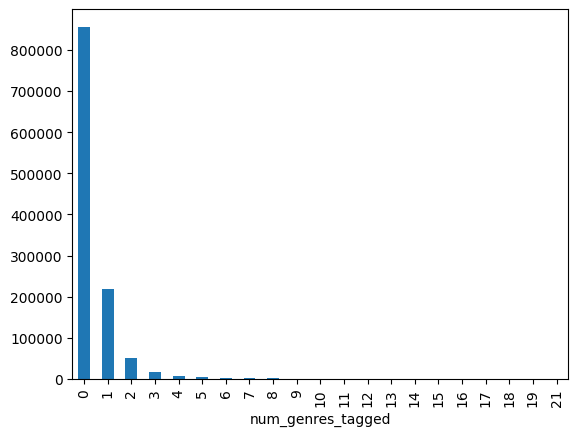

In [81]:
df_db_artists['num_genres_tagged'].value_counts().plot(kind='bar')

In [149]:
interested_artists = {
    "Lauv": "5JZ7CnR6gTvEMKX4g70Amv",
    "LANY": "49tQo2QULno7gxHutgccqF",
    "Avicii": "1vCWHaC5f2uS3yhpwWbIA6",
    "A R I Z O N A": "7hOGhpa8RMSuDOWntGIAJt",
    "Don Diablo": "1l2ekx5skC4gJH8djERwh1",
    "Steve Aoki": "77AiFEVeAVj2ORpC85QVJs",
    "Tale Of Us": "1UL813H5aj3e8ekE5RqWqc",
    "Green Day": "7oPftvlwr6VrsViSDV7fJY",
    "U2": "51Blml2LZPmy7TTiAg47vQ",
    "Metallica": "2ye2Wgw4gimLv2eAKyk1NB",
    "Dean Martin": "49e4v89VmlDcFCMyDv9wQ9",
    "Diplo": "5fMUXHkw8R8eOP2RNVYEZX",
    "Faithless": "5T4UKHhr4HGIC0VzdZQtAE",
    "Bicep": "73A3bLnfnz5BoQjb4gNCga",
    "Four Tet": "7Eu1txygG6nJttLHbZdQOh",
    "RHCP": "0L8ExT028jH3ddEcZwqJJ5",
    "Flume": "6nxWCVXbOlEVRexSbLsTer",
    "Skrillex": "5he5w2lnU9x7JFhnwcekXX",
    "James Bay": "4EzkuveR9pLvDVFNx6foYD",
    "Ed Sheeran": "6eUKZXaKkcviH0Ku9w2n3V",
    "Dua Lipa": "6M2wZ9GZgrQXHCFfjv46we",
    "Monkey Safari": "5zovXI5By2gUhdr7EByjLa",
    "Britney Spears": "26dSoYclwsYLMAKD3tpOr4",
    "Bruno Mars": "0du5cEVh5yTK9QJze8zA0C",
    "Martin Garrix": "60d24wfXkVzDSfLS6hyCjZ",
    "CamelPhat": "240wlM8vDrf6S4zCyzGj2W",
    "Drake": "3TVXtAsR1Inumwj472S9r4",
    "Khalid": "6LuN9FCkKOj5PcnpouEgny",
    "Pop Smoke": "0eDvMgVFoNV3TpwtrVCoTj",
    "DVBBS": "5X4LWwbUFNzPkEas04uU82",
    "Timmy Trumpet": "0CbeG1224FS58EUx4tPevZ",
    "Dimitri Vegas & Like Mike": "73jBynjsVtofjRpdpRAJGk"
}

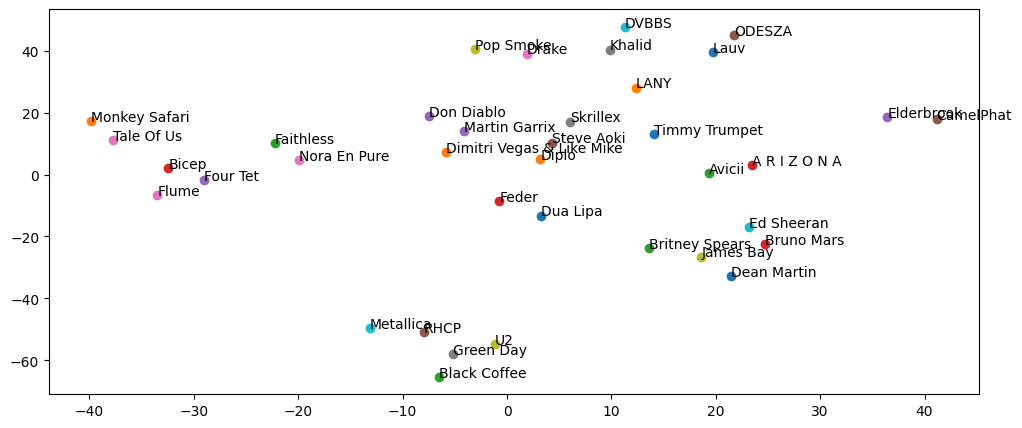

In [150]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tokens = []
labels = []

for name in interested_artists:
    labels.append(name)
    tokens.append(mdl.wv.get_vector(interested_artists[name]))

tsne_model = TSNE(perplexity=5, n_components=2, init='pca', n_iter=2000, random_state=13, metric='cosine')
new_values = tsne_model.fit_transform(np.array(tokens))

x = []
y = []
for value in new_values:
    x.append(value[0])
    y.append(value[1])
    
fig, ax = plt.subplots(figsize=(12,5)) 
for i in range(len(x)):
    ax.scatter(x[i], y[i])
    
for i, txt in enumerate(labels):
    ax.annotate(txt, (x[i], y[i]))

plt.show()

## Imputing missing values

Some artists are not in this graph since we didn't find any relationship => we have to impute the missing values

### 1. Load Genre Embeddings

In [89]:
genre_embeddings = np.load('../models/genre_embeddings_bert_v1.npy', allow_pickle=True)

### 2. Find All Missing Artists

In [93]:
missing_artists = []

for artist_id in artist_information:
    if artist_id not in mdl.wv:
        missing_artists.append(artist_id)

### 3. Create an "Genre Based Artist Embeddings"

--> average all embeddings for each genre tag for each artist

In [121]:
artist_genre_based_embeddings = {}
missing_artists_set = set(missing_artists)

for artist_id, artist in artist_information.items():

    embeddings = []
    
    for genre in artist['genres']:
        genre_embedding = genre_embeddings.item().get(genre)
        if genre_embedding is not None:
            embeddings.append(genre_embedding)
    
    if len(embeddings) > 1:
        artist_genre_based_embeddings[artist_id] = np.average(embeddings, axis=0)
    elif len(embeddings) == 1:
        artist_genre_based_embeddings[artist_id] = embeddings[0]

In [122]:
len(artist_genre_based_embeddings)

274819

### 4. Do NN on the new Artist embeddings

Find for each artist missing an embedding the K nearest artists based on genres

Then assign the artist missing an embedding the average artist embeddings of the K nearest artists

In [123]:
potential_hits = {artist_id: val for artist_id, val in artist_genre_based_embeddings.items() if artist_id not in missing_artists_set}
potential_hits_artist_ids = list(potential_hits.keys())
potential_hits_artist_genre_embeddings = list(potential_hits.values())

In [124]:
from sklearn.neighbors import NearestNeighbors

nn = NearestNeighbors(n_neighbors=4, metric="cosine")
nn.fit(potential_hits_artist_genre_embeddings)

NearestNeighbors(metric='cosine', n_neighbors=4)

In [132]:
imputations = {}

for artist_id in missing_artists:
    
    if artist_id not in artist_genre_based_embeddings:
        continue

    neighbors = nn.kneighbors([artist_genre_based_embeddings[artist_id]])
    
    neighbors_embeddings = []
    for neighbor_index in neighbors[1][0]:
        hit_artist_id = potential_hits_artist_ids[neighbor_index]
        neighbors_embeddings.append(mdl.wv.get_vector(hit_artist_id))
        
    artist_imputed_embedding = np.average(neighbors_embeddings, axis=0)
    imputations[artist_id] = artist_imputed_embedding

In [133]:
len(imputations)

232210

In [134]:
mdl.wv.add_vectors(list(imputations.keys()), list(imputations.values()))

### 5. Store the new model

In [135]:
mdl.save("../models/artist_embedding_with_imputation_v6.model")

### Preview

In [146]:
df_db_artists[df_db_artists['name']=="Nora En Pure"]

,id,followers,genres,name,popularity,num_genres_tagged
144914,24DO0PijjITGIEWsO8XaPs,252378.0,"[deep house, 'deep tropical house, 'electra,...",Nora En Pure,67,8


In [147]:
interested_artists = {
    "Lauv": "5JZ7CnR6gTvEMKX4g70Amv",
    "LANY": "49tQo2QULno7gxHutgccqF",
    "Avicii": "1vCWHaC5f2uS3yhpwWbIA6",
    "A R I Z O N A": "7hOGhpa8RMSuDOWntGIAJt",
    "Don Diablo": "1l2ekx5skC4gJH8djERwh1",
    "Steve Aoki": "77AiFEVeAVj2ORpC85QVJs",
    "Tale Of Us": "1UL813H5aj3e8ekE5RqWqc",
    "Green Day": "7oPftvlwr6VrsViSDV7fJY",
    "U2": "51Blml2LZPmy7TTiAg47vQ",
    "Metallica": "2ye2Wgw4gimLv2eAKyk1NB",
    "Dean Martin": "49e4v89VmlDcFCMyDv9wQ9",
    "Diplo": "5fMUXHkw8R8eOP2RNVYEZX",
    "Faithless": "5T4UKHhr4HGIC0VzdZQtAE",
    "Bicep": "73A3bLnfnz5BoQjb4gNCga",
    "Four Tet": "7Eu1txygG6nJttLHbZdQOh",
    "RHCP": "0L8ExT028jH3ddEcZwqJJ5",
    "Flume": "6nxWCVXbOlEVRexSbLsTer",
    "Skrillex": "5he5w2lnU9x7JFhnwcekXX",
    "James Bay": "4EzkuveR9pLvDVFNx6foYD",
    "Ed Sheeran": "6eUKZXaKkcviH0Ku9w2n3V",
    "Dua Lipa": "6M2wZ9GZgrQXHCFfjv46we",
    "Monkey Safari": "5zovXI5By2gUhdr7EByjLa",
    "Britney Spears": "26dSoYclwsYLMAKD3tpOr4",
    "Bruno Mars": "0du5cEVh5yTK9QJze8zA0C",
    "Martin Garrix": "60d24wfXkVzDSfLS6hyCjZ",
    "CamelPhat": "240wlM8vDrf6S4zCyzGj2W",
    "Drake": "3TVXtAsR1Inumwj472S9r4",
    "Khalid": "6LuN9FCkKOj5PcnpouEgny",
    "Pop Smoke": "0eDvMgVFoNV3TpwtrVCoTj",
    "DVBBS": "5X4LWwbUFNzPkEas04uU82",
    "Timmy Trumpet": "0CbeG1224FS58EUx4tPevZ",
    "Dimitri Vegas & Like Mike": "73jBynjsVtofjRpdpRAJGk",
    "Black Coffee": "6wMr4zKPrrR0UVz08WtUWc",
    "Feder": "5KnoVkIUGmK0PiDKMjz2LM",
    "Elderbrook": "2vf4pRsEY6LpL5tKmqWb64",
    "ODESZA": "21mKp7DqtSNHhCAU2ugvUw",
    "Nora En Pure": "24DO0PijjITGIEWsO8XaPs"
}

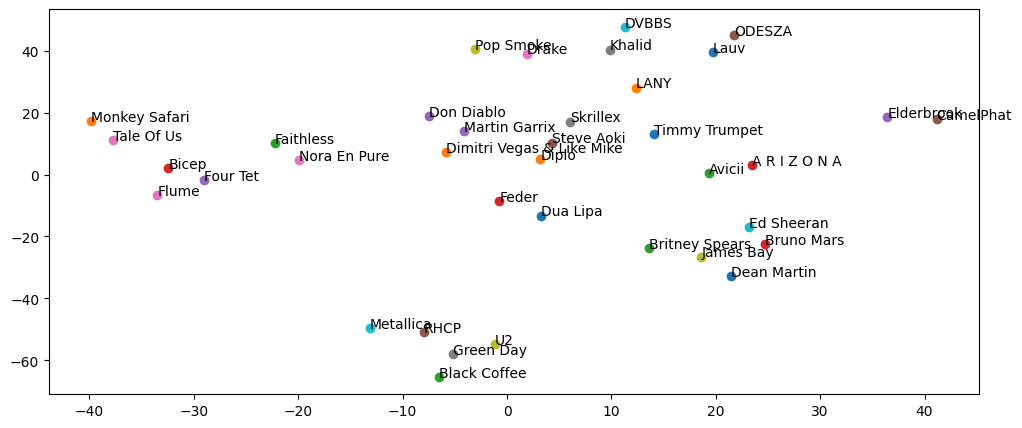

In [148]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tokens = []
labels = []

for name in interested_artists:
    labels.append(name)
    tokens.append(mdl.wv.get_vector(interested_artists[name]))

tsne_model = TSNE(perplexity=5, n_components=2, init='pca', n_iter=2000, random_state=13, metric='cosine')
new_values = tsne_model.fit_transform(np.array(tokens))

x = []
y = []
for value in new_values:
    x.append(value[0])
    y.append(value[1])
    
fig, ax = plt.subplots(figsize=(12,5)) 
for i in range(len(x)):
    ax.scatter(x[i], y[i])
    
for i, txt in enumerate(labels):
    ax.annotate(txt, (x[i], y[i]))

plt.show()